### Importing Libraries.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import Caltech101
from torchvision.transforms import ToTensor, Resize, Compose
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Downloading the datasets.

In [2]:
# Downloading CIFAR10 dataset.
transform = Compose([
    Resize((128, 128)),  # Resize all images to 128x128
    ToTensor()           # Convert images to tensors
])

data = Caltech101('Caltech101', download = True, transform=transform)

train_data, test_data = train_test_split(data, test_size=0.2, shuffle= True, random_state=28)

print(len(train_data),len(test_data))

Files already downloaded and verified
6941 1736


### Checking an image.

0


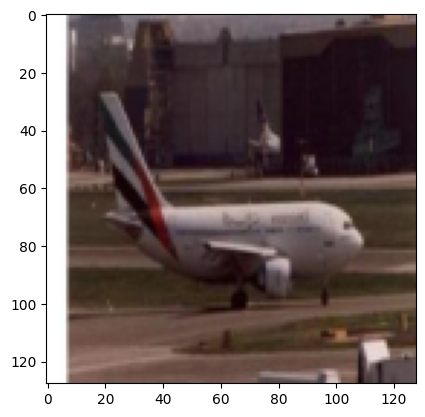

In [3]:
# Image label pairs.
print(train_data[0][1])
plt.imshow(test_data[10][0].permute(1,2,0))
plt.show()

### Creating a task set from the context and target points.

In [4]:
def get_context_target_sets(images_data, no_of_context_target_points,Image_shape):
    m,n = Image_shape

    # All coordinates of the image.
    All_coordinates = np.array([(i,j) for i in range (m) for j in range (n)])
    
    # Iterate on dataset to create context set and target set.
    task_set =  []
    for i in tqdm(range(len(images_data))):

        if images_data[i][0].shape[0]<3:
            continue

        image, _ = images_data[i]
        #image = image.squeeze()
        # Context point indexes
        context_idx = np.random.choice(range(len(All_coordinates)), no_of_context_target_points, replace = False)

        # Context points and corresponding pixel values.
        context_points = All_coordinates[context_idx]
        image = image.permute(1, 2, 0)
        context_pixels = image[context_points[:,0], context_points[:,1]]

        # Concatenating context points and corresponding pixel values.
        context_set = np.concatenate([context_points, context_pixels],axis=-1).astype(np.float32)

        # Giving pixel values for all pixels in image to predcit all the points given on grid .
        target_points = All_coordinates
        target_pixels = image[target_points[:,0], target_points[:,1]]
        
        # concatenate target points and corresponding pixel values.
        target_set = np.concatenate([target_points, target_pixels], axis = -1).astype(np.float32)
        task_set.append([context_set,target_set])
        
    return task_set

### Generating the train set.

In [14]:
train_set = get_context_target_sets(images_data=train_data, no_of_context_target_points=2500, Image_shape=(128,128))
train_dataloader = DataLoader(train_set, batch_size=1, shuffle= True)
for context_pairs,target_pairs in train_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    # print(i.shape)
    break

100%|██████████| 6941/6941 [00:06<00:00, 1111.19it/s]

torch.Size([1, 2500, 5]) torch.Size([1, 16384, 5])


### Generating the test set.

In [15]:
test_set = get_context_target_sets(images_data=test_data, no_of_context_target_points=2500, Image_shape=(128,128))
test_dataloader = DataLoader(test_set, batch_size=1, shuffle= True)
for context_pairs, target_pairs in test_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 1736/1736 [00:01<00:00, 907.66it/s]

torch.Size([1, 2500, 5]) torch.Size([1, 16384, 5])


### Creating the Neural Process Class and defining the forward propagation, train and test functions.

In [16]:
class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)
    
class Neural_process_model(nn.Module):
    def __init__(self, device):
        super(Neural_process_model, self).__init__()
        if device == 'cuda':
            if torch.cuda.is_available():
                device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        self.device = device
        
        self.encoder = nn.Sequential(
                                    nn.Linear(5,64),
                                    Sin(),
                                    nn.Linear(64,128),
                                    Sin(),
                                    nn.Linear(128,256),
                                    Sin(),
                                    nn.Linear(256,512)
                                    )
        self.decoder = nn.Sequential(
                                    nn.Linear(512+2, 256),
                                    Sin(),
                                    nn.Linear(256,128),
                                    Sin(),
                                    nn.Linear(128,64),
                                    Sin(),
                                    nn.Linear(64,32),
                                    Sin(),
                                    nn.Linear(32,3)
                                    )
        
    def forward(self, context_pairs, target_pairs):
        latent_representation = self.encoder(context_pairs)
        # print(latent_representation)
        latent_representation = torch.mean(latent_representation, dim = 1)
        latent_representation = latent_representation.unsqueeze(1).repeat(1, target_pairs.size(1),1)

        # Cocatenating latent representation with target pixel locations.
        target_pixel_locations = target_pairs[:,:,:2]
        target = torch.cat([latent_representation, target_pixel_locations], dim = -1)

        # decode target pairs to obtain the predicted target pixel intensity
        predicted_target_pixel_intensity = self.decoder(target)
        
        return predicted_target_pixel_intensity
    
    def train(self, train_dataloader, num_epochs =100, optim = torch.optim.Adam, lr = 3e-4, criterion = nn.MSELoss(), verbose = True):
        device = self.device
        optimiser = optim(self.parameters(), lr = lr)

        best_loss = float("inf")    # Initialize with infinity
        best_model_state = None     # To hold the state dict of the best model

        for epoch in range(num_epochs):
            for _, (context_pairs, target_pairs) in enumerate(train_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                optimiser.zero_grad()
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)
                loss = criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
                loss.backward()
                optimiser.step()
            if verbose:
                print("Epoch: {}/{} Loss: {:.5f}".format(epoch+1,num_epochs,loss.item()))

            # After each epoch, check if the current loss is the best loss
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_model_state = self.state_dict().copy()

        if best_model_state:
            self.load_state_dict(best_model_state)
            
        if verbose:
            print(f"Model updated to best state with loss: {best_loss:.5f}")

    def test(self, test_dataloader, criterion = nn.MSELoss()):
        device = self.device
        self.to(device)
        test_loss = 0
        with torch.no_grad():
            for i, context_pairs, target_pairs, in enumerate(test_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)

            loss =  criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
            test_loss += loss.item()
        print(f'Test Loss: {test_loss/len(test_dataloader)}')

### Checking the avialable device.

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

model = Neural_process_model(device = 'cuda')

cuda


### Training the model.

In [18]:
model.to(device)
model.train(train_dataloader, num_epochs=10)

Epoch: 1/10 Loss: 0.01508
Epoch: 2/10 Loss: 0.03373
Epoch: 3/10 Loss: 0.06681
Epoch: 4/10 Loss: 0.04636
Epoch: 5/10 Loss: 0.03484
Epoch: 6/10 Loss: 0.02630
Epoch: 7/10 Loss: 0.02623
Epoch: 8/10 Loss: 0.01811
Epoch: 9/10 Loss: 0.03885
Epoch: 10/10 Loss: 0.01731
Model updated to best state with loss: 0.01508


### Testing the Neural Process.

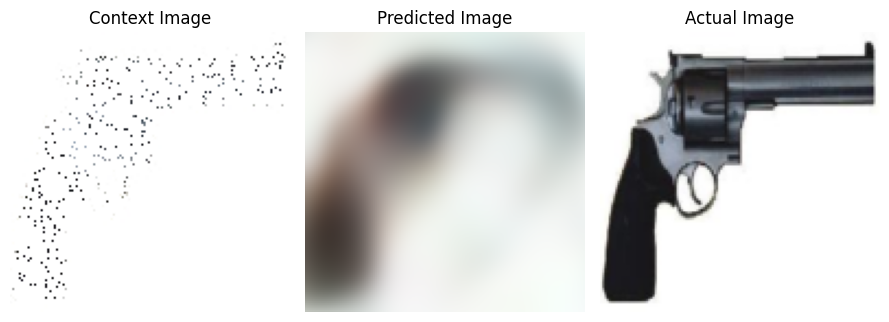

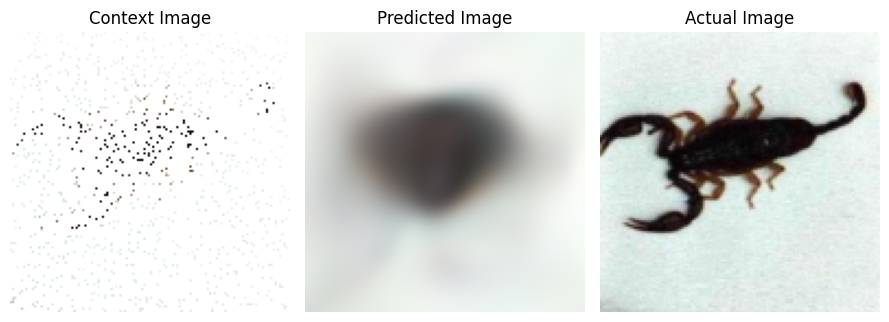

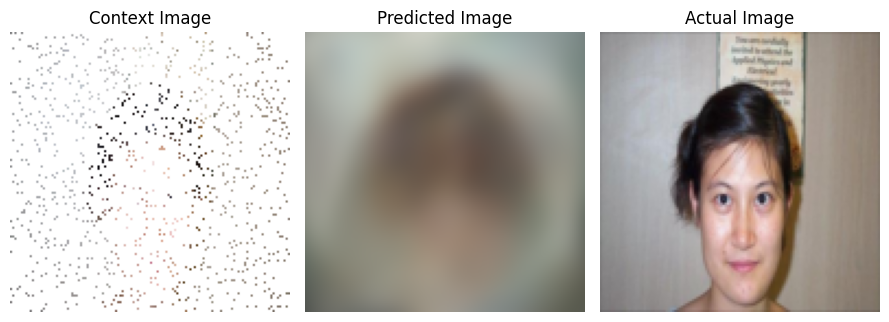

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10696658..0.7642831].


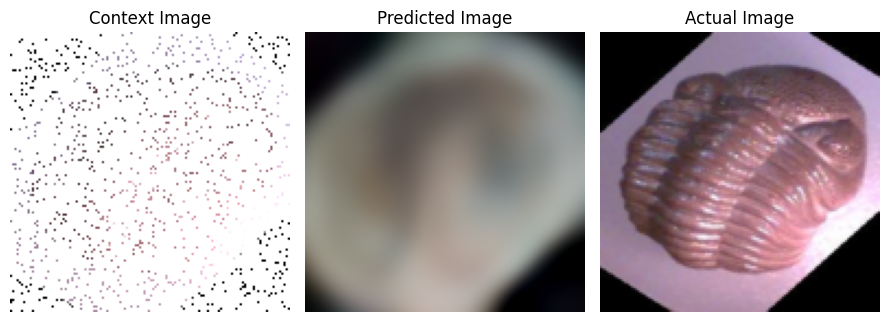

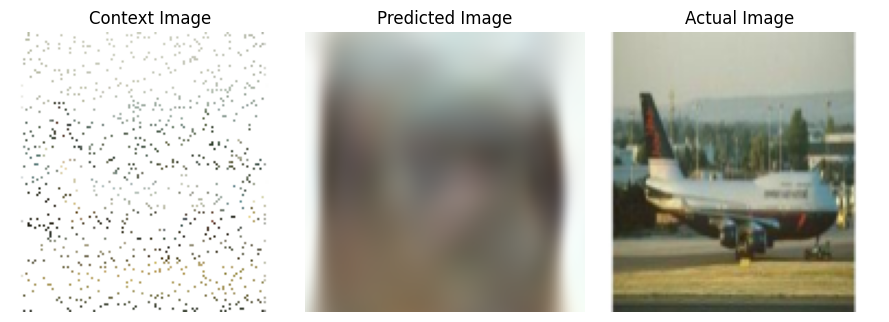

In [13]:
# testing the neural process.
for idx,(context_pairs, target_pairs) in enumerate(test_dataloader):
    context_pairs = context_pairs.to(device)
    target_pairs  = target_pairs.to(device)
    model.to(device)

    predicted_target_pixel_intensity = model(context_pairs, target_pairs)
    # for i in range(10):
    predicted_pixel = predicted_target_pixel_intensity.detach().cpu().numpy()
    predicted_image = predicted_pixel.reshape(128,128,3)

    actual_pixel = target_pairs[:,:,2:].detach().cpu().numpy()
    actual_image = actual_pixel.reshape(128,128,3)

    context_image = np.ones((128,128,3))
    context_pixel_locations = context_pairs[:,:,:2].detach().cpu().numpy().astype(int)
    context_image[context_pixel_locations[:,:,0], context_pixel_locations[:,:,1]] = context_pairs[:,:,2:].detach().cpu().numpy()

    plt.figure(figsize=(9,4))

    plt.subplot(1,3,1)
    plt.imshow(context_image)
    plt.axis('off')
    plt.title('Context Image')
    
    plt.subplot(1,3,2)
    plt.imshow(predicted_image)
    plt.axis('off')
    plt.title('Predicted Image')

    plt.subplot(1,3,3)
    plt.imshow(actual_image)
    plt.axis('off')
    plt.title('Actual Image')
    
    plt.tight_layout()
    plt.show()

    if idx>3:
        break